# Diffusion for two grains in contact


### Functions

In [1]:
# Importing required libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize_scalar
from scipy.stats import chisquare, pearsonr
import copy



def diff_matrix_isolated_boundary_G2(N1, N, alpha_1, alpha_2):
    """
    Create the matrices A and B for the Crank-Nicolson method with isolated boundary conditions
    for two grains.

    Parameters:
        N1 (int): Number of points in the first grain.
        N (int): Total number of points.
        alpha_1 (float): Diffusion coefficient for the first grain.
        alpha_2 (float): Diffusion coefficient for the second grain.

    Returns:
        tuple: Two matrices A and B.
    """

    # Initialize matrices A and B with zeros
    A = [[0] * N for _ in range(N)]
    B = [[0] * N for _ in range(N)]

    # Fill diagonal and off-diagonal values for matrices A and B
    for i in range(N1):
        A[i][i] = 2 + 2 * alpha_1  # Diagonal element of A
        B[i][i] = 2 - 2 * alpha_1  # Diagonal element of B

        # Connect to the left neighbor (if not on the left edge)
        if i > 0:
            A[i][i - 1] = -alpha_1
            B[i][i - 1] = alpha_1

        # Connect to the right neighbor (if not on the right edge)
        if i < N - 1:
            A[i][i + 1] = -alpha_1
            B[i][i + 1] = alpha_1

    # Fill diagonal and off-diagonal values for matrices A and B
    for i in range(N1, N):
        A[i][i] = 2 + 2 * alpha_2  # Diagonal element of A
        B[i][i] = 2 - 2 * alpha_2  # Diagonal element of B

        # Connect to the left neighbor (if not on the left edge)
        if i > 0:
            A[i][i - 1] = -alpha_2
            B[i][i - 1] = alpha_2

        # Connect to the right neighbor (if not on the right edge)
        if i < N - 1:
            A[i][i + 1] = -alpha_2
            B[i][i + 1] = alpha_2


    # Boundary conditions
    A[0][0] = 2 + alpha_1
    B[0][0] = 2 - alpha_1
    A[-1][-1] = 2 + alpha_2
    B[-1][-1] = 2 - alpha_2

    return A, B


def crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff_1, Diff_2, X, init_cond_1, init_cond_2, source_term, boundary):
    """
    Solve the diffusion equation using the Crank-Nicolson method.

    Parameters:
        L_grain1 (float): Length of the first grain.
        L_grain2 (float): Length of the second grain.
        t_max (float): Maximum time.
        dl (float): Spatial step size.
        dt (float): Temporal step size.
        Diff_1 (float): Diffusion coefficient for the first grain.
        Diff_2 (float): Diffusion coefficient for the second grain.
        X (ndarray): Array of spatial points.
        init_cond_1 (callable): Initial condition for the first grain.
        init_cond_2 (callable): Initial condition for the second grain.
        source_term (callable): Source term function.
        boundary (callable): Function to create the matrices A and B.

    Returns:
        ndarray: Solution of the diffusion equation.
        ndarray: Array of spatial points.
        ndarray: Array of time points.
    """

    # Spatial grid
    N1 = int(L_grain1 / (L_grain1 + L_grain2) * len(X))
    N2 = len(X) - N1
    N = N1 + N2
    dl = (L_grain1+L_grain2) / (N)
    x = [i*dl for i in range(N)]
    t = [j*dt for j in range(int(t_max/dt))]

    alpha_1 = Diff_1 * dt / (dl**2)
    alpha_2 = Diff_2 * dt / (dl**2)

    # Initialize temperature array
    Temp = np.zeros((len(x), len(t)))

    # Initial condition
    for i in range(N1):
        Temp[i][0] = init_cond_1(X)
    for i in range(N1, len(x)):
        Temp[i][0] = init_cond_2(X)

    # Get the matrices for solving the matrix using crank-nicolson method
    A, B = boundary(N1, len(x), alpha_1, alpha_2)

    A = np.array(A)
    B = np.array(B)

    for j in range(1, len(t)):
        source_vector = np.array([source_term(xi, t[j]) for xi in x])
        Temp[:, j] = np.linalg.solve(A, np.dot(B, Temp[:, j - 1]) + dt * source_vector)

    return Temp, np.array(x), np.array(t)

def plot_diff(time_grid, spatial_grid, solution_Mg, solution_Fe, Dist, X_Mg, X_Fe, X_Mn=None, solution_Mn=None):
    """
    Plot the solution of the diffusion equation.

    Parameters:
        time_grid (ndarray): Array of time points.
        spatial_grid (ndarray): Array of spatial points.
        solution (ndarray): Solution of the diffusion equation.
        Dist (ndarray): Distance data.
        X_Mg (ndarray): Mg concentration data.
        X_Fe (ndarray): Fe concentration data.
    """

    # Create 2D plots
    if X_Mn is None and solution_Mn is None:
        plt.figure(figsize=(12, 3.5))
        plt.subplot(1, 2, 1)
        plt.plot(Dist, X_Mg, 'o', label='Data')
        plt.plot(spatial_grid, solution_Mg[:, -1], linewidth=3, label=f'time = '+str(round(time_grid[-1], 1)))
        plt.xlabel(r'Grain length ($\mu m$)')
        plt.ylabel(r'X_Mg concentration')
        plt.title('Diffusion and element partitioning in Magnesium')
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(Dist, X_Fe, 'o', label='Data')
        plt.plot(spatial_grid, solution_Fe[:, -1], linewidth=3, label=f'time = '+str(round(time_grid[-1], 1)))
        plt.xlabel(r'Grain length ($\mu m$)')
        plt.ylabel(r'X_Fe concentration')
        plt.title('Diffusion and element partitioning in one Iron')
        plt.grid()
        plt.legend()

    else:
        plt.figure(figsize=(15, 3.5))
        plt.subplot(1, 3, 1)
        plt.plot(Dist, X_Mg, 'o', label='Data')
        plt.plot(spatial_grid, solution_Mg[:, -1], linewidth=3, label=f'time = '+str(round(time_grid[-1], 1)))
        plt.xlabel(r'Grain length ($\mu m$)')
        plt.ylabel(r'X_Mg concentration')
        plt.title('Diffusion and element partitioning in Magnesium')
        plt.grid()
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(Dist, X_Fe, 'o', label='Data')
        plt.plot(spatial_grid, solution_Fe[:, -1], linewidth=3, label=f'time = '+str(round(time_grid[-1], 1)))
        plt.xlabel(r'Grain length ($\mu m$)')
        plt.ylabel(r'X_Fe concentration')
        plt.title('Diffusion and element partitioning in Iron')
        plt.grid()
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(Dist, X_Mn, 'o', label='Data')
        plt.plot(spatial_grid, solution_Mn[:, -1], linewidth=3, label=f'time = '+str(round(time_grid[-1], 1)))
        plt.xlabel(r'Grain length ($\mu m$)')
        plt.ylabel(r'X_Mn concentration')
        plt.title('Diffusion and element partitioning in Manganese')
        plt.grid()
        plt.legend()

    plt.tight_layout()

def find_max_solution(f, a, b, tol=1e-6, max_iter=100):
    """
    Golden section search algorithm for maximizing a univariate function.

    Parameters:
        f (callable): The objective function.
        a (float): The lower bound of the search interval.
        b (float): The upper bound of the search interval.
        tol (float): Tolerance for stopping criterion (default: 1e-5).
        max_iter (int): Maximum number of iterations (default: 100).

    Returns:
        float: The maximum value of the function.
        float: The value of the argument at the maximum.
    """

    phi = (1 + 5 ** 0.5) / 2  # Golden ratio
    c = b - (b - a) / phi
    d = a + (b - a) / phi
    while abs(c - d) > tol and max_iter > 0:
        if f(c) > f(d):  # Change the comparison to '>' for maximization
            b = d
        else:
            a = c
        c = b - (b - a) / phi
        d = a + (b - a) / phi
        max_iter -= 1
    return (b + a) / 2, f((b + a) / 2)


# Function to linear fit the data
def Line_fit(X, Y):
    n = len(X) # or len(Y)
    xbar = sum(X)/n
    ybar = sum(Y)/n

    # Calculating numerator and denominator
    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    # calculation of slope and intercept
    m = numer / denum
    c = ybar - m * xbar
    return c, m






In [2]:
Diffusivity_array = []
Temperature_array = []
fO2_array = []


# OLID 202 data - Obtaining the optimum fit for diffusivity 

Calculating best fit for diffusion coefficient for Magnesium...
Diffusion coefficient: 0.6202360509234234
Pearson R: 0.9998367835373181



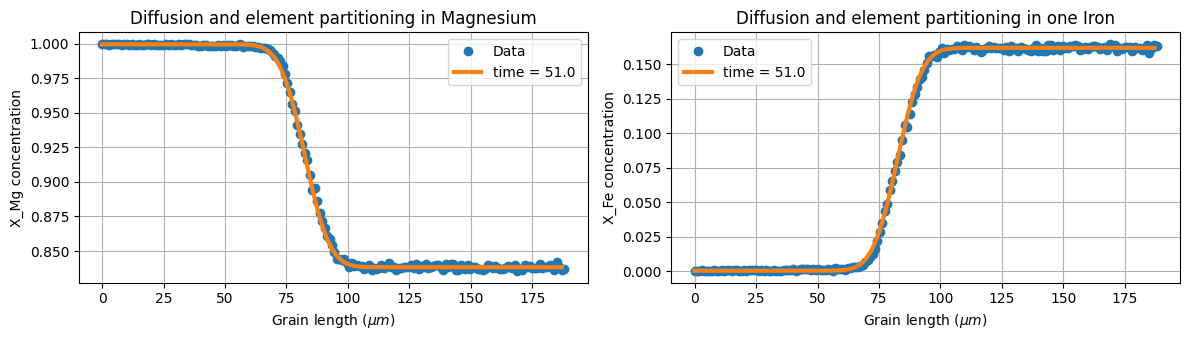

In [3]:
DATA = np.loadtxt('/home/ws1/Computational-Physics-Term-Paper-Project/Element_Partitioning_and_Diffusion/PS2_OLID_202.csv', delimiter="\t", skiprows=6)
Dist = DATA[:, 0]
X_Mg = DATA[:, 1]
X_Fe = DATA[:, 2]

# Constants and parameters
tol = 1e-6
t_max = 51.5     # total simulation time
L_grain1 = 83     # length of the grain 1
L_grain2 = 105     # length of the grain 2
dt = 0.5       # time step
z_max = L_grain1 + L_grain2
dl = z_max / (len(Dist))

def source_term(x, t):
    return 0

########################################### X_Mg ###########################################

def init_X_Mg_left(X_Mg):
    # Initial condition for at the left side of the Magnesium data - average of the first 20 data points
    return np.average(X_Mg[:20])

def init_X_Mg_right(X_Mg):
    # Initial condition for at the right side of the Magnesium data - average of the last 20 data points
    return np.average(X_Mg[-20:-1])

def func_Mg(Diff):
    # Function to calculate the Pearson R for Magnesium
    solution_Mg, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mg, 
                                                                    init_X_Mg_left, init_X_Mg_right, source_term, 
                                                                    diff_matrix_isolated_boundary_G2)
    pearson_R_Mg = pearsonr(X_Mg, solution_Mg[:, -1])[0]
    return pearson_R_Mg

print('Calculating best fit for diffusion coefficient for Magnesium...')
Diff, _ = find_max_solution(func_Mg, 1e-4, 1, tol=tol)
print('Diffusion coefficient:', Diff)
print('Pearson R:', func_Mg(Diff))

print()

########################################### X_Fe ###########################################

def init_X_Fe_left(X_Fe):
    # Initial condition for at the left side of the Iron data - average of the first 20 data points
    return np.average(X_Fe[:20])

def init_X_Fe_right(X_Fe):
    # Initial condition for at the right side of the Iron data - average of the last 20 data points
    return np.average(X_Fe[-20:-1])

# def func_Fe(Diff):
    # Function to calculate the Pearson R for Iron
    # solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, 
                                                                    # init_X_Fe_left, init_X_Fe_right, source_term, 
                                                                    # diff_matrix_isolated_boundary_G2)
#     pearson_R_Fe = pearsonr(X_Fe, solution_Fe[:, -1])[0]
#     return pearson_R_Fe

# print('Calculating best fit for diffusion coefficient for Iron...')
# Diff, _ = find_max_solution(func_Fe, 1e-4, 1, tol=tol)
# print('Diffusion coefficient:', Diff)
# print('Pearson R:', func_Fe(Diff))

# print()

Diffusivity_array.append(Diff)
Temperature_array.append(1300)
fO2_array.append(-12.04)

solution_Mg, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mg, init_X_Mg_left, init_X_Mg_right, source_term, diff_matrix_isolated_boundary_G2)
solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, init_X_Fe_left, init_X_Fe_right, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_Mg, solution_Fe, Dist, X_Mg, X_Fe)
plt.show()


# OLID 8 data - Obtaining the optimum fit for diffusivity 

Calculating best fit for diffusion coefficient for Magnesium...
Diffusion coefficient: 0.01909768526605877
Pearson R: 0.9993361687034651



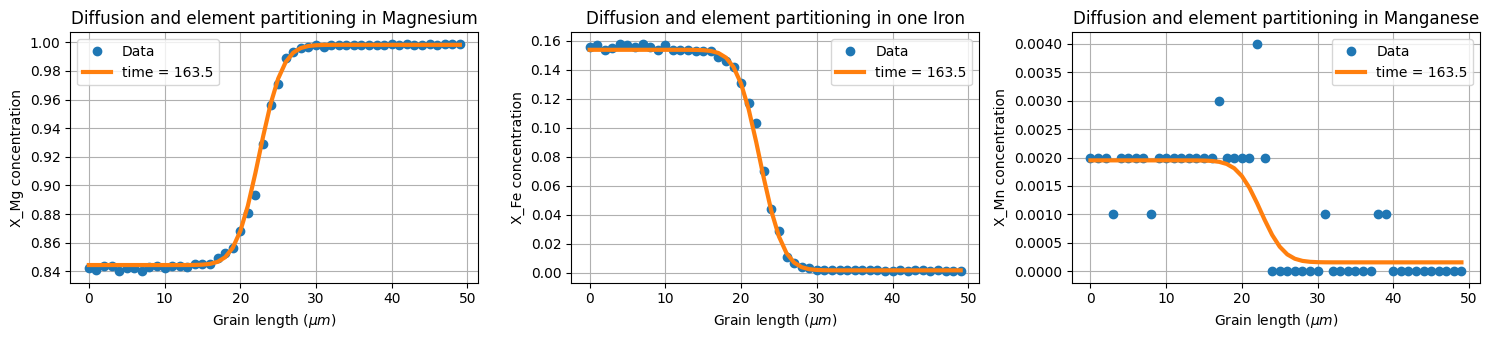

In [4]:
DATA = np.loadtxt('/home/ws1/Computational-Physics-Term-Paper-Project/Element_Partitioning_and_Diffusion/PS2_OLID_8.csv', delimiter="\t", skiprows=6)
Dist = DATA[:, 0]
X_Mg = DATA[:, 2]
X_Fe = DATA[:, 3]
X_Mn = DATA[:, 1]

# Constants and parameters
tol = 1e-6
t_max = 164     # total simulation time
L_grain1 = 23.5     # length of the grain 1
L_grain2 = 50-23.5     # length of the grain 2
dt = 0.5       # time step
z_max = L_grain1 + L_grain2
dl = z_max / (len(Dist))

def source_term(x, t):
    return 0

########################################### X_Mg ###########################################

def init_X_Mg_left(X_Mg):
    # Initial condition for at the left side of the Magnesium data - average of the first 20 data points
    return np.average(X_Mg[:20])

def init_X_Mg_right(X_Mg):
    # Initial condition for at the right side of the Magnesium data - average of the last 20 data points
    return np.average(X_Mg[-20:-1])

def func_Mg(Diff):
    # Function to calculate the Pearson R for Magnesium
    solution_Mg, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mg, 
                                                                    init_X_Mg_left, init_X_Mg_right, source_term, 
                                                                    diff_matrix_isolated_boundary_G2)
    pearson_R_Mg = pearsonr(X_Mg, solution_Mg[:, -1])[0]
    return pearson_R_Mg

print('Calculating best fit for diffusion coefficient for Magnesium...')
Diff, _ = find_max_solution(func_Mg, 1e-4, 1, tol=tol)
print('Diffusion coefficient:', Diff)
print('Pearson R:', func_Mg(Diff))

print()

########################################### X_Fe ###########################################

def init_X_Fe_left(X_Fe):
    # Initial condition for at the left side of the Iron data - average of the first 20 data points
    return np.average(X_Fe[:20])

def init_X_Fe_right(X_Fe):
    # Initial condition for at the right side of the Iron data - average of the last 20 data points
    return np.average(X_Fe[-20:-1])

# def func_Fe(Diff):
#     # Function to calculate the Pearson R for Iron
#     solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, 
#                                                                     init_X_Fe_left, init_X_Fe_right, source_term, 
#                                                                     diff_matrix_isolated_boundary_G2)
#     pearson_R_Fe = pearsonr(X_Fe, solution_Fe[:, -1])[0]
#     return pearson_R_Fe

# print('Calculating best fit for diffusion coefficient for Iron...')
# Diff, _ = find_max_solution(func_Fe, 1e-4, 1, tol=tol)
# print('Diffusion coefficient:', Diff)
# print('Pearson R:', func_Fe(Diff))

# print()

########################################### X_Fe ###########################################

def init_X_Mn_left(X_Mn):
    # Initial condition for at the left side of the Manganese data - average of the first 20 data points
    return np.average(X_Mn[:20])

def init_X_Mn_right(X_Mn):
    # Initial condition for at the right side of the Manganese data - average of the last 20 data points
    return np.average(X_Mn[-20:-1])

# def func_Fe(Diff):
#     # Function to calculate the Pearson R for Iron
#     solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, 
#                                                                     init_X_Fe_left, init_X_Fe_right, source_term, 
#                                                                     diff_matrix_isolated_boundary_G2)
#     pearson_R_Fe = pearsonr(X_Fe, solution_Fe[:, -1])[0]
#     return pearson_R_Fe

# print('Calculating best fit for diffusion coefficient for Iron...')
# Diff, _ = find_max_solution(func_Fe, 1e-4, 1, tol=tol)
# print('Diffusion coefficient:', Diff)
# print('Pearson R:', func_Fe(Diff))

# print()

Diffusivity_array.append(Diff)
Temperature_array.append(1100)
fO2_array.append(-12.02)

solution_Mg, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mg, init_X_Mg_left, init_X_Mg_right, source_term, diff_matrix_isolated_boundary_G2)
solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, init_X_Fe_left, init_X_Fe_right, source_term, diff_matrix_isolated_boundary_G2)
solution_Mn, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mn, init_X_Mn_left, init_X_Mn_right, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_Mg, solution_Fe, Dist, X_Mg, X_Fe, X_Mn, solution_Mn)
plt.show()


# OLID 9 data - Obtaining the optimum fit for diffusivity 

Calculating best fit for diffusion coefficient for Magnesium...
Diffusion coefficient: 0.14338580765351916
Pearson R: 0.9997160771864197



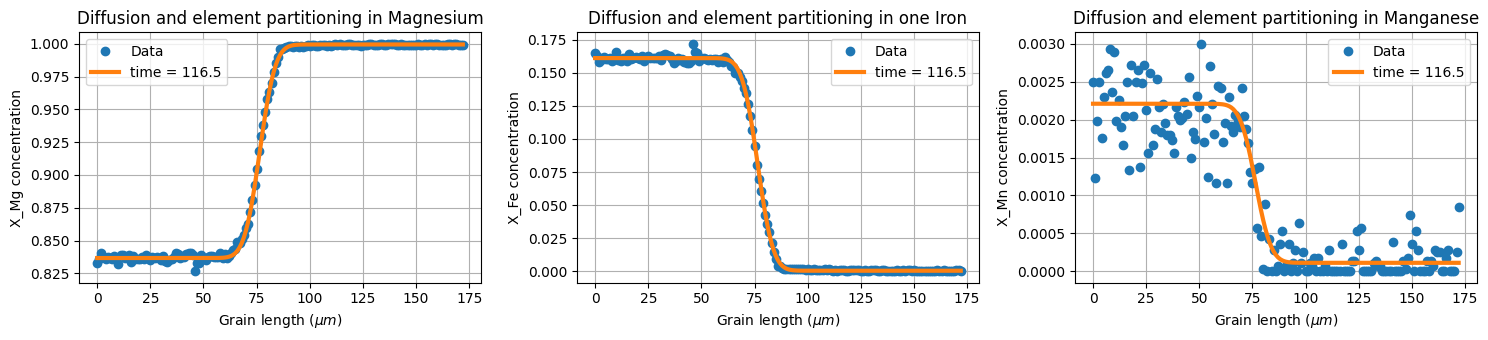

In [5]:
DATA = np.loadtxt('/home/ws1/Computational-Physics-Term-Paper-Project/Element_Partitioning_and_Diffusion/PS2_OLID_9.csv', delimiter="\t", skiprows=6)
Dist = DATA[:, 0]
X_Mg = DATA[:, 2]
X_Fe = DATA[:, 3]
X_Mn = DATA[:, 1]

# Constants and parameters
tol = 1e-6
t_max = 117     # total simulation time
L_grain1 = 77     # length of the grain 1
L_grain2 = 173-77     # length of the grain 2
dt = 0.5       # time step
z_max = L_grain1 + L_grain2
dl = z_max / (len(Dist))

def source_term(x, t):
    return 0

########################################### X_Mg ###########################################

def init_X_Mg_left(X_Mg):
    # Initial condition for at the left side of the Magnesium data - average of the first 20 data points
    return np.average(X_Mg[:20])

def init_X_Mg_right(X_Mg):
    # Initial condition for at the right side of the Magnesium data - average of the last 20 data points
    return np.average(X_Mg[-20:-1])

def func_Mg(Diff):
    # Function to calculate the Pearson R for Magnesium
    solution_Mg, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mg, 
                                                                    init_X_Mg_left, init_X_Mg_right, source_term, 
                                                                    diff_matrix_isolated_boundary_G2)
    pearson_R_Mg = pearsonr(X_Mg, solution_Mg[:, -1])[0]
    return pearson_R_Mg

print('Calculating best fit for diffusion coefficient for Magnesium...')
Diff, _ = find_max_solution(func_Mg, 1e-4, 1, tol=tol)
print('Diffusion coefficient:', Diff)
print('Pearson R:', func_Mg(Diff))

print()

########################################### X_Fe ###########################################

def init_X_Fe_left(X_Fe):
    # Initial condition for at the left side of the Iron data - average of the first 20 data points
    return np.average(X_Fe[:20])

def init_X_Fe_right(X_Fe):
    # Initial condition for at the right side of the Iron data - average of the last 20 data points
    return np.average(X_Fe[-20:-1])

# def func_Fe(Diff):
#     # Function to calculate the Pearson R for Iron
#     solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, 
#                                                                     init_X_Fe_left, init_X_Fe_right, source_term, 
#                                                                     diff_matrix_isolated_boundary_G2)
#     pearson_R_Fe = pearsonr(X_Fe, solution_Fe[:, -1])[0]
#     return pearson_R_Fe

# print('Calculating best fit for diffusion coefficient for Iron...')
# Diff, _ = find_max_solution(func_Fe, 1e-4, 1, tol=tol)
# print('Diffusion coefficient:', Diff)
# print('Pearson R:', func_Fe(Diff))

# print()

########################################### X_Fe ###########################################

def init_X_Mn_left(X_Mn):
    # Initial condition for at the left side of the Manganese data - average of the first 20 data points
    return np.average(X_Mn[:20])

def init_X_Mn_right(X_Mn):
    # Initial condition for at the right side of the Manganese data - average of the last 20 data points
    return np.average(X_Mn[-20:-1])

# def func_Fe(Diff):
#     # Function to calculate the Pearson R for Iron
#     solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, 
#                                                                     init_X_Fe_left, init_X_Fe_right, source_term, 
#                                                                     diff_matrix_isolated_boundary_G2)
#     pearson_R_Fe = pearsonr(X_Fe, solution_Fe[:, -1])[0]
#     return pearson_R_Fe

# print('Calculating best fit for diffusion coefficient for Iron...')
# Diff, _ = find_max_solution(func_Fe, 1e-4, 1, tol=tol)
# print('Diffusion coefficient:', Diff)
# print('Pearson R:', func_Fe(Diff))

# print()

Diffusivity_array.append(Diff)
Temperature_array.append(1200)
fO2_array.append(-11.98)

solution_Mg, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mg, init_X_Mg_left, init_X_Mg_right, source_term, diff_matrix_isolated_boundary_G2)
solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, init_X_Fe_left, init_X_Fe_right, source_term, diff_matrix_isolated_boundary_G2)
solution_Mn, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mn, init_X_Mn_left, init_X_Mn_right, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_Mg, solution_Fe, Dist, X_Mg, X_Fe, X_Mn, solution_Mn)
plt.show()


# OLID 10 data - Obtaining the optimum fit for diffusivity 

Calculating best fit for diffusion coefficient for Magnesium...
Diffusion coefficient: 0.010254103272418939
Pearson R: 0.9995740594508039



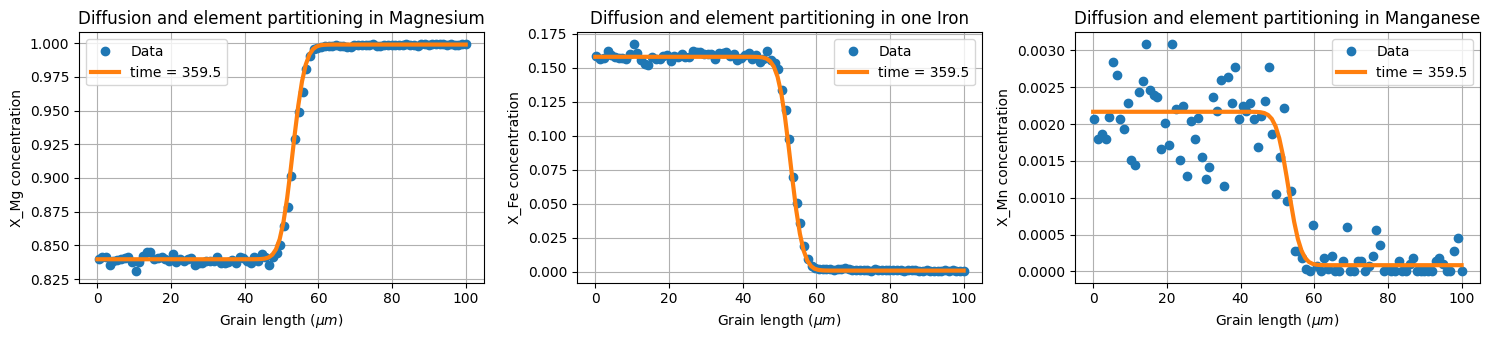

In [6]:
DATA = np.loadtxt('/home/ws1/Computational-Physics-Term-Paper-Project/Element_Partitioning_and_Diffusion/PS2_OLID_10.csv', delimiter="\t", skiprows=6)
Dist = DATA[:, 0]-201
X_Mg = DATA[:, 2]
X_Fe = DATA[:, 3]
X_Mn = DATA[:, 1]

# Constants and parameters
tol = 1e-6
t_max = 360     # total simulation time
L_grain1 = 54.5     # length of the grain 1
L_grain2 = 101-54.5     # length of the grain 2
dt = 0.5       # time step
z_max = L_grain1 + L_grain2
dl = z_max / (len(Dist))

def source_term(x, t):
    return 0

########################################### X_Mg ###########################################

def init_X_Mg_left(X_Mg):
    # Initial condition for at the left side of the Magnesium data - average of the first 20 data points
    return np.average(X_Mg[:20])

def init_X_Mg_right(X_Mg):
    # Initial condition for at the right side of the Magnesium data - average of the last 20 data points
    return np.average(X_Mg[-20:-1])

def func_Mg(Diff):
    # Function to calculate the Pearson R for Magnesium
    solution_Mg, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mg, 
                                                                    init_X_Mg_left, init_X_Mg_right, source_term, 
                                                                    diff_matrix_isolated_boundary_G2)
    pearson_R_Mg = pearsonr(X_Mg, solution_Mg[:, -1])[0]
    return pearson_R_Mg

print('Calculating best fit for diffusion coefficient for Magnesium...')
Diff, _ = find_max_solution(func_Mg, 1e-4, 1, tol=tol)
print('Diffusion coefficient:', Diff)
print('Pearson R:', func_Mg(Diff))

print()

########################################### X_Fe ###########################################

def init_X_Fe_left(X_Fe):
    # Initial condition for at the left side of the Iron data - average of the first 20 data points
    return np.average(X_Fe[:20])

def init_X_Fe_right(X_Fe):
    # Initial condition for at the right side of the Iron data - average of the last 20 data points
    return np.average(X_Fe[-20:-1])

# def func_Fe(Diff):
#     # Function to calculate the Pearson R for Iron
#     solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, 
#                                                                     init_X_Fe_left, init_X_Fe_right, source_term, 
#                                                                     diff_matrix_isolated_boundary_G2)
#     pearson_R_Fe = pearsonr(X_Fe, solution_Fe[:, -1])[0]
#     return pearson_R_Fe

# print('Calculating best fit for diffusion coefficient for Iron...')
# Diff, _ = find_max_solution(func_Fe, 1e-4, 1, tol=tol)
# print('Diffusion coefficient:', Diff)
# print('Pearson R:', func_Fe(Diff))

# print()

########################################### X_Fe ###########################################

def init_X_Mn_left(X_Mn):
    # Initial condition for at the left side of the Manganese data - average of the first 20 data points
    return np.average(X_Mn[:20])

def init_X_Mn_right(X_Mn):
    # Initial condition for at the right side of the Manganese data - average of the last 20 data points
    return np.average(X_Mn[-20:-1])

# def func_Fe(Diff):
#     # Function to calculate the Pearson R for Iron
#     solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, 
#                                                                     init_X_Fe_left, init_X_Fe_right, source_term, 
#                                                                     diff_matrix_isolated_boundary_G2)
#     pearson_R_Fe = pearsonr(X_Fe, solution_Fe[:, -1])[0]
#     return pearson_R_Fe

# print('Calculating best fit for diffusion coefficient for Iron...')
# Diff, _ = find_max_solution(func_Fe, 1e-4, 1, tol=tol)
# print('Diffusion coefficient:', Diff)
# print('Pearson R:', func_Fe(Diff))

# print()

Diffusivity_array.append(Diff)
Temperature_array.append(1000)
fO2_array.append(-11.97)

solution_Mg, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mg, init_X_Mg_left, init_X_Mg_right, source_term, diff_matrix_isolated_boundary_G2)
solution_Fe, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fe, init_X_Fe_left, init_X_Fe_right, source_term, diff_matrix_isolated_boundary_G2)
solution_Mn, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Mn, init_X_Mn_left, init_X_Mn_right, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_Mg, solution_Fe, Dist, X_Mg, X_Fe, X_Mn, solution_Mn)
plt.show()


# Calculation of Arrhenius coefficient

The Arrhenius relation is given as

$$ D = D_0 \exp \left(-\dfrac{Q}{RT} \right) $$ 

$D_0$ = Diffusivity at zero temperature

$Q$ = Activation energy

$R$ = Universal gas constant


Slope: 0.01432323837989472
Intercept: -19.211258373862453
Pearson R: 0.9825878208903409

Pre-exponential factor: 4.535827166535776e-09
Activation Energy: -0.11908340389044471 J/mol


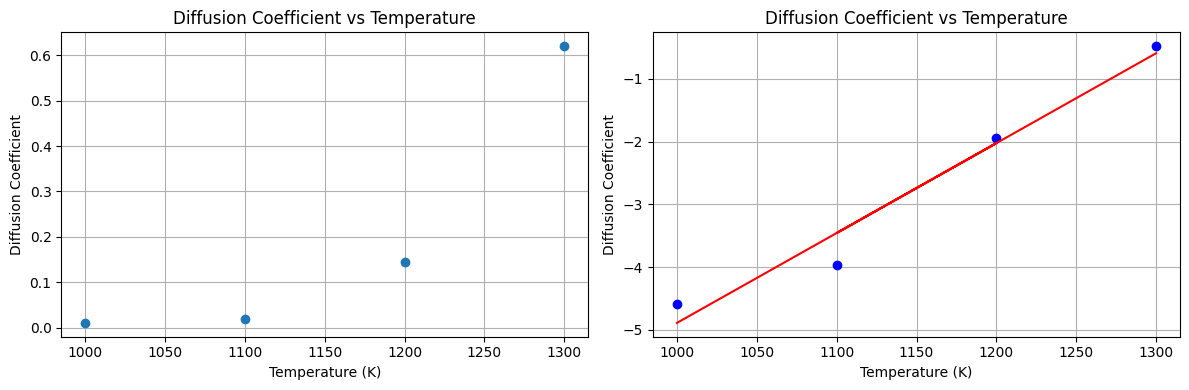

In [7]:
Diffusivity_array = np.array(Diffusivity_array)
Temperature_array = np.array(Temperature_array)
fO2_array = np.array(fO2_array)

c, m = Line_fit(Temperature_array, np.log(Diffusivity_array))
Pearson_R = pearsonr(Temperature_array, np.log(Diffusivity_array))[0]
print('Slope:', m)
print('Intercept:', c)
print('Pearson R:', Pearson_R)
print()

D0 = np.exp(c)
print('Pre-exponential factor:', D0)
Q = -m * 8.314
print('Activation Energy:', Q, 'J/mol')


# Plotting the points
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(Temperature_array, Diffusivity_array, 'o')
plt.xlabel('Temperature (K)')
plt.ylabel('Diffusion Coefficient')
plt.title('Diffusion Coefficient vs Temperature')
plt.grid()

# Plotting the log plot and linear fit
plt.subplot(1, 2, 2)
plt.plot(Temperature_array, np.log(Diffusivity_array), 'bo')
yfit = [c + m * xi for xi in Temperature_array]
plt.plot(Temperature_array, yfit, 'r-', label="Best fit line")
plt.xlabel('Temperature (K)')
plt.ylabel('Diffusion Coefficient')
plt.title('Diffusion Coefficient vs Temperature')
plt.grid()

plt.tight_layout()
plt.show()

